In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

# Overview of the data

### Campaign Desc
* Description (TypeA, TypeB, TypeC)
* Campaign Id
* Start and End Day

### Campaign Table
* Description
* Campaign Id
* Houshold key

### Casual Data
* Product Id
* Store Id
* Week
* Display location (Ad in in-store display? )
* Mailer Location (Featured as ad in weekly mailer)

### Coupon Redemption
* Household Id
* Day
* Coupon Id
* Campaign Id

### Coupon
* Coupon Id
* Product Id
* Campaign Id

### Demographic
* Age (19-65+)
* Marital Status Code (A: Married, B: Single, U: Unknown)
* Income
* Homeowner (Homeowner, Renter, etc.)
* Household composition (Female/Male single, adults with/without kids, etc.)
* Household size
* Number of kids (1-3+)
* Household Id

### Products
* Product Id
* Manufacturer Id
* Departement (grocery, pastry, etc.)
* Brand (national/private)
* Commodity description
* Sub commodity description
* Size

### Transaction
* Household Id
* Manufacturer Id
* Week
* Day
* Time of Day
* Product Id
* Quantity
* Sales value (What shop actually gets)
* Store Id
* Retail discount (Loyalty program of retailer)
* Coupon discount (Shop does not get price before discount)
* Coupon match discount (Shop does get price before discount)






# Loading the data

Let's start by loading the data in pandas dataframes.

## Campaign desc

In [2]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')

In [3]:
df_campaign_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [4]:
print('Number of campaign: ', len(df_campaign_desc.CAMPAIGN))
print('Unique description: ', df_campaign_desc.DESCRIPTION.unique())

Number of campaign:  30
Unique description:  ['TypeB' 'TypeC' 'TypeA']


Let's add a column with the duration of each campaign

In [5]:
df_campaign_desc['DURATION'] = df_campaign_desc['END_DAY'] - df_campaign_desc['START_DAY'] 
df_campaign_desc.sort_values(by = ['DESCRIPTION', 'DURATION'])

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,DURATION
29,TypeA,26,224,264,40
25,TypeA,30,323,369,46
12,TypeA,13,504,551,47
17,TypeA,8,412,460,48
7,TypeA,18,587,642,55
2,TypeB,25,659,691,32
5,TypeB,21,624,656,32
6,TypeB,22,624,656,32
8,TypeB,19,603,635,32
9,TypeB,17,575,607,32


## Campaign table

In [6]:
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')

In [7]:
df_campaign_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Let's study the distribution of the number of campaigns each household has benefited from.

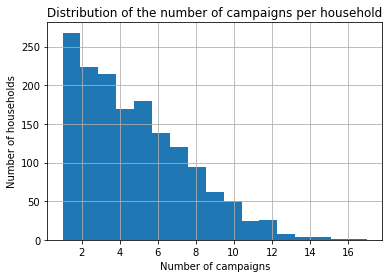

In [8]:
nbins = df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max()
df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().hist(bins = nbins)
plt.title('Distribution of the number of campaigns per household')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.show()

In [9]:
print('Mean number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().mean())
print('Median number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().median())
print('Max number of campaigns:', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().max())
print('25% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.25),
      'campaigns or less.')
print('75% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.75),
      'campaigns or less.')
print('95% of the households have benefited from', df_campaign_table.groupby(by = 'household_key').CAMPAIGN.count().quantile(q = 0.95),
      'campaigns or less.')

Mean number of campaigns: 4.55050505050505
Median number of campaigns: 4.0
Max number of campaigns: 17
25% of the households have benefited from 2.0 campaigns or less.
75% of the households have benefited from 6.0 campaigns or less.
95% of the households have benefited from 10.0 campaigns or less.


## Causal data

In [10]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')

In [11]:
df_causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's define two dict for the code meaning of display and mailer.

In [12]:
display_dict = {0:'Not on Display', 1:'Store Front', 2:'Store Rear', 3:'Front End Cap',
                4:'Mid-Aisle End Cap', 5:'Read End Cap' ,6:'Side-Aisle End Cap', 7:'In-Aisle' ,
                9:'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {0:'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

## Coupon redemption

In [13]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')

In [14]:
df_coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


## Coupon

In [15]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')

In [16]:
df_coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's study how many coupons were distributed for each campaign.

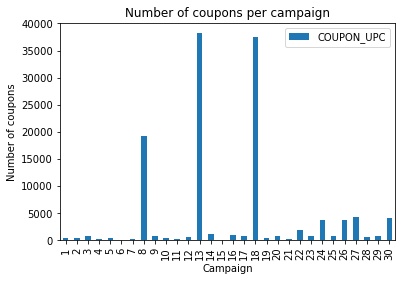

In [17]:
df_coupon.groupby(by = 'CAMPAIGN').count().plot.bar(y = 'COUPON_UPC')
plt.xlabel('Campaign')
plt.ylabel('Number of coupons')
plt.title('Number of coupons per campaign')
plt.show()

We notice there are definetely some campaigns with way more coupons than others. Is this related to the type of campaign?

## Demographics

In [18]:
df_demo = pd.read_csv('dunnhumby/hh_demographic.csv')

In [19]:
print(df_demo.head(20))
df_demo["AGE_DESC"].unique()

   AGE_DESC MARITAL_STATUS_CODE INCOME_DESC   HOMEOWNER_DESC  \
0       65+                   A      35-49K        Homeowner   
1     45-54                   A      50-74K        Homeowner   
2     25-34                   U      25-34K          Unknown   
3     25-34                   U      75-99K        Homeowner   
4     45-54                   B      50-74K        Homeowner   
5       65+                   B   Under 15K        Homeowner   
6     45-54                   A    100-124K        Homeowner   
7     35-44                   B      15-24K          Unknown   
8     25-34                   A      75-99K           Renter   
9     45-54                   A      75-99K        Homeowner   
10    35-44                   U      50-74K          Unknown   
11    45-54                   U      25-34K  Probable Renter   
12    35-44                   B      35-49K        Homeowner   
13    35-44                   A    125-149K        Homeowner   
14    45-54                   U   Under 

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

## Products

In [20]:
df_products = pd.read_csv('dunnhumby/product.csv')

Let's explore the product data frame and filter out anything food related. We start by looking at the column *DEPARTMENT*.

In [21]:
list_dep = np.sort(df_products["DEPARTMENT"].unique())
list_commodity = np.sort(df_products["COMMODITY_DESC"].unique())
list_sub = np.sort(df_products["SUB_COMMODITY_DESC"].unique())

frames = {}
for l in list_dep:    
    frames[l] = df_products[df_products["DEPARTMENT"].apply(lambda x : x == l)]

In [22]:
print(df_products.groupby("DEPARTMENT").count()["PRODUCT_ID"].sort_values(ascending=False))

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
POSTAL CENTER          3
DAIRY DELI             3
TOYS                   3
VIDEO RENTAL           3
GM MERCH EXP           3
PHOTO                  2
DELI/SNACK BAR         2
PROD-WHS SALES         2
GRO BAKERY             2
CHARITABLE CONT        2
AUTOMOTIVE             2
VIDEO                  2
PORK                   1
ELECT &PLUMBIN

Let's observe the biggest categories and see whats in it.

In [23]:
frames["GROCERY"]["COMMODITY_DESC"].unique()

array(['FRZN ICE', 'FRUIT - SHELF STABLE', 'COOKIES/CONES',
       'SPICES & EXTRACTS', 'PNT BTR/JELLY/JAMS',
       'ICE CREAM/MILK/SHERBTS', 'AIR CARE', 'CHEESE', 'SHORTENING/OIL',
       'COFFEE', 'PAPER HOUSEWARES', 'BAKED BREAD/BUNS/ROLLS',
       'VEGETABLES - SHELF STABLE', 'HISPANIC', 'DINNER MXS:DRY',
       'CONDIMENTS/SAUCES', 'FRZN VEGETABLE/VEG DSH', 'BAKING NEEDS',
       'FRZN FRUITS', 'HOUSEHOLD CLEANG NEEDS', 'FD WRAPS/BAGS/TRSH BG',
       'DRY MIX DESSERTS', 'PICKLE/RELISH/PKLD VEG', 'BAKING MIXES',
       'FLUID MILK PRODUCTS', 'SOUP', 'BAKED SWEET GOODS',
       'DRY BN/VEG/POTATO/RICE', 'FACIAL TISS/DNR NAPKIN', 'FROZEN PIZZA',
       'EGGS', 'REFRGRATD DOUGH PRODUCTS', 'HOT CEREAL', 'COLD CEREAL',
       'SUGARS/SWEETNERS', 'SEAFOOD - SHELF STABLE', 'CANNED JUICES',
       'BAG SNACKS', 'BEANS - CANNED GLASS & MW', 'CRACKERS/MISC BKD FD',
       'CONVENIENT BRKFST/WHLSM SNACKS', 'SOFT DRINKS', 'BUTTER',
       'FRZN MEAT/MEAT DINNERS', 'WATER - CARBONATED/FLVRD D

As expected the category **Grocery** is all over the place and contains basically anything what can be bought in a grocery store. The category is not really helpful and we have to check the sub categories.

Lets check **Drug Gm** next and see, if there is anythin food-related in it.

In [24]:
frames["DRUG GM"]["COMMODITY_DESC"].unique()

array(['VITAMINS', 'MAGAZINE', 'DIETARY AID PRODUCTS',
       'STATIONERY & SCHOOL SUPPLIES', 'COLD AND FLU', 'BABY HBC',
       'SOAP - LIQUID & BAR', 'KITCHEN GADGETS', 'CANDY - PACKAGED',
       'HAIR CARE PRODUCTS', 'CANDY - CHECKLANE', 'SHAVING CARE PRODUCTS',
       'FIRST AID PRODUCTS', 'NEWSPAPER', 'INSECTICIDES',
       'ELECTRICAL SUPPPLIES', 'IRONING AND CHEMICALS', 'ANALGESICS',
       'HOSIERY/SOCKS', 'BATTERIES', 'BOOKSTORE',
       'SPRING/SUMMER SEASONAL', 'CHARCOAL AND LIGHTER FLUID',
       'HAND/BODY/FACIAL PRODUCTS', 'ORAL HYGIENE PRODUCTS',
       'INFANT FORMULA', 'DEODORANTS', 'FEMININE HYGIENE',
       'COFFEE FILTERS', 'BROOMS AND MOPS',
       'GREETING CARDS/WRAP/PARTY SPLY', 'HARDWARE SUPPLIES', 'ANTACIDS',
       'CIGARETTES', 'BABY FOODS', 'SINUS AND ALLERGY',
       'INFANT CARE PRODUCTS', 'TOBACCO OTHER',
       'FILM AND CAMERA PRODUCTS', 'PLASTIC HOUSEWARES',
       'FOOT CARE PRODUCTS', 'SHOE CARE', 'FIREWORKS', 'SUNTAN',
       'CANDLES/ACCESSORIES',

* 'DIETARY AID PRODUCTS' (candy bar, novelty candy, candy bags-chocolate)
* 'CANDY - PACKAGED'
* 'CANDY - CHECKLANE'
* 'INFANT FORMULA'
* 'BABY FOODS' 
* 'DOMESTIC GOODS'
* 'NATURAL HBC' (novelty candy)

After looking at the commodities individually , these do have some food related stuff in them.

In the end the following *DEPARTMENT* values are food related. There still some a lot of non food items. We have to filter them out.

In [64]:
list_dep_food = ["GROCERY", "DRUG GM", "PRODUCE", "NUTRITION", "MEAT","MEAT-PCKGD","DELI","PASTRY", "SEAFOOD-PCKGD", "SEAFOOD", 
                 "RESTAURANT", "MISC SALES TRAN", "SALAD BAR", "TRAVEL & LEISUR", "FROZEN GROCERY", "CHEF SHOPPE", "DAIRY DELI", 
                 "GM MERCH EXP", "DELI/SNACK BAR", "GRO BAKERY", "PORK", "MEAT-WHSE"]
non_food = ["COSMETICS", "FLORAL", "CHARITABLE CONT", "MISC. TRANS.", "SPIRITS", "GARDEN CENTER", 
            "COUP/STR & MFG", "KIOSK-GAS", "RX", "CNTRL/STORE SUP", "POSTAL CENTER", "TOYS", 
            "VIDEO RENTAL", "PHOTO", "PROD-WHS SALES", "CHARITABLE CONT", "AUTOMOTIVE", "VIDEO", 
            "ELECT &PLUMBING","HOUSEWARES", "PHARMACY SUPPLY", "HBC", " "]
print(list_dep_food)

['GROCERY', 'DRUG GM', 'PRODUCE', 'NUTRITION', 'MEAT', 'MEAT-PCKGD', 'DELI', 'PASTRY', 'SEAFOOD-PCKGD', 'SEAFOOD', 'RESTAURANT', 'MISC SALES TRAN', 'SALAD BAR', 'TRAVEL & LEISUR', 'FROZEN GROCERY', 'CHEF SHOPPE', 'DAIRY DELI', 'GM MERCH EXP', 'DELI/SNACK BAR', 'GRO BAKERY', 'PORK', 'MEAT-WHSE']


In [77]:
df_food = df_products[df_products["DEPARTMENT"].apply(lambda x : x in list_dep_food)]
np.sort(df_food["COMMODITY_DESC"].unique())
df_meat = df_food[df_food["COMMODITY_DESC"].str.contains("MEAT")]
df_fish = df_

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
123,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
156,31493,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,10 OZ
274,34997,1329,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12 OZ
319,36406,1329,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,12 OZ
322,36561,165,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN MULTI SERVE ENTREES ALL,22 OZ
...,...,...,...,...,...,...,...
92221,18107338,1094,MEAT-PCKGD,National,LUNCHMEAT,LUNCH COMBO,6.8 OZ
92223,18107424,1094,MEAT-PCKGD,National,LUNCHMEAT,LUNCH COMBO,7.1 OZ
92259,18147446,69,MEAT-PCKGD,Private,LUNCHMEAT,VARIETY PACK,10 OZ
92275,18148186,1251,GROCERY,National,FRZN MEAT/MEAT DINNERS,SS ECONOMY ENTREES/DINNERS ALL,14 OZ


## Transcation data

In [ ]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')

In [ ]:
df_transaction.head()